## Appendix

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [2]:
# read the different data sets into the notebook
bids_df = pd.read_csv('C:/Users/tysir/bids.csv')
train_df = pd.read_csv('C:/Users/tysir/bids.train.csv')

In [3]:
print("Head of bids_df:")
print(bids_df.head())

Head of bids_df:
   bid_id                              bidder_id auction merchandise  device  \
0       0  8dac2b259fd1c6d1120e519fb1ac14fbqvax8   ewmzr     jewelry  phone0   
1       1  668d393e858e8126275433046bbd35c6tywop   aeqok   furniture  phone1   
2       2  aa5f360084278b35d746fa6af3a7a1a5ra3xe   wa00e  home goods  phone2   
3       3  3939ac3ef7d472a59a9c5f893dd3e39fh9ofi   jefix     jewelry  phone4   
4       4  8393c48eaf4b8fa96886edc7cf27b372dsibi   jefix     jewelry  phone5   

               time country              ip              url  
0  9759243157894736      us   69.166.231.58  vasstdc27m7nks3  
1  9759243157894736      in   50.201.125.84  jmqlhflrzwuay9c  
2  9759243157894736      py  112.54.208.157  vasstdc27m7nks3  
3  9759243157894736      in   18.99.175.133  vasstdc27m7nks3  
4  9759243157894736      in    145.138.5.37  vasstdc27m7nks3  


In [4]:
print("\nHead of train_df:")
print(train_df.head())


Head of train_df:
                               bidder_id  \
0  91a3c57b13234af24875c56fb7e2b2f4rb56a   
1  624f258b49e77713fc34034560f93fb3hu3jo   
2  1c5f4fc669099bfbfac515cd26997bd12ruaj   
3  4bee9aba2abda51bf43d639013d6efe12iycd   
4  4ab12bc61c82ddd9c2d65e60555808acqgos1   

                         payment_account  \
0  a3d2de7675556553a5f08e4c88d2c228754av   
1  a3d2de7675556553a5f08e4c88d2c228v1sga   
2  a3d2de7675556553a5f08e4c88d2c2280cybl   
3  51d80e233f7b6a7dfdee484a3c120f3b2ita8   
4  a3d2de7675556553a5f08e4c88d2c22857ddh   

                                 address  outcome  
0  a3d2de7675556553a5f08e4c88d2c228vt0u4      0.0  
1  ae87054e5a97a8f840a3991d12611fdcrfbq3      0.0  
2  92520288b50f03907041887884ba49c0cl0pd      0.0  
3  4cb9717c8ad7e88a9a284989dd79b98dbevyi      0.0  
4  2a96c3ce94b3be921e0296097b88b56a7x1ji      0.0  


In [5]:
bids_df.shape

(7656334, 9)

In [6]:
# null values
bids_df.isnull().sum()

bid_id            0
bidder_id         0
auction           0
merchandise       0
device            0
time              0
country        8859
ip                0
url               0
dtype: int64

In [7]:
# mode imputation for country NA values
bids_df['country'] = bids_df['country'].fillna(bids_df['country'].mode()[0])

In [8]:
bids_df.isnull().sum()

bid_id         0
bidder_id      0
auction        0
merchandise    0
device         0
time           0
country        0
ip             0
url            0
dtype: int64

In [9]:
# congregate data by the unique bidder_id
bidder_unique = bids_df.groupby("bidder_id").nunique().reset_index()
bidder_unique.head()

,bidder_id,bid_id,auction,merchandise,device,time,country,ip,url
0,001068c415025a009fee375a12cff4fcnht8y,1,1,1,1,1,1,1,1
1,002d229ffb247009810828f648afc2ef593rb,2,1,1,2,2,1,1,1
2,0030a2dd87ad2733e0873062e4f83954mkj86,1,1,1,1,1,1,1,1
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3,3,1,3,3,1,3,2
4,00486a11dff552c4bd7696265724ff81yeo9v,20,13,1,8,20,1,10,7


#### Merge the train data set based on the unique bidder_id

In [10]:
train_set = train_df.merge(bidder_unique, on='bidder_id', how='left').drop(columns = ['payment_account', 'address'], errors = 'ignore')
train_set = train_set.rename(columns = {'bid_id': 'num_bids', 'auction': 'num_auct', 'merchandise': 'num_merch_type', 'device': 'num_device_type', 'time': 'num_time', 'country': 'num_ctry', 'ip': 'num_ip', 'url': 'num_url'})
train_set = train_set.fillna(0)

train_set.head()

,bidder_id,outcome,num_bids,num_auct,num_merch_type,num_device_type,num_time,num_ctry,num_ip,num_url
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,0.0,24.0,18.0,1.0,14.0,24.0,6.0,20.0,1.0
1,624f258b49e77713fc34034560f93fb3hu3jo,0.0,3.0,1.0,1.0,2.0,3.0,1.0,3.0,2.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,0.0,4.0,4.0,1.0,2.0,4.0,1.0,4.0,2.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,0.0,155.0,23.0,1.0,53.0,155.0,2.0,123.0,91.0


### Exploratory Data Analysis

In [11]:
# shape of the training data set
train_set.shape

(2013, 10)

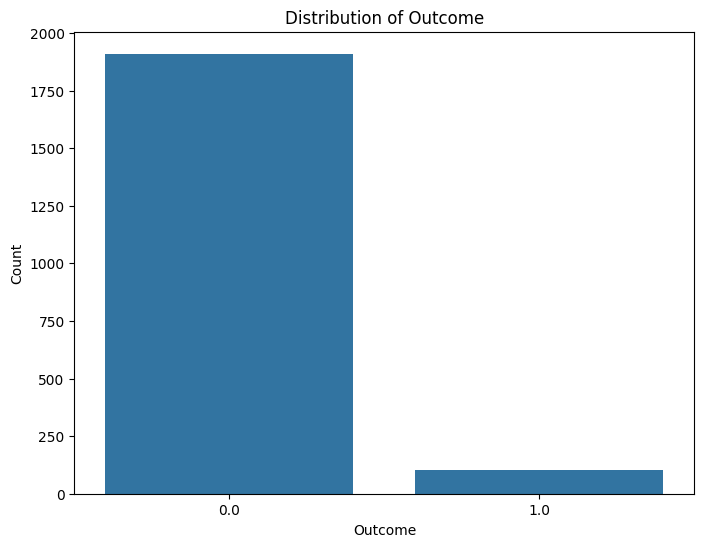

In [12]:
# distribution of the target variable outcome
plt.figure(figsize=(8, 6))
sns.countplot(data=train_set, x='outcome')
plt.title('Distribution of Outcome')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

In [13]:
# outcome counts
outcome_counts = train_set['outcome'].value_counts()
print(outcome_counts)

0.0    1910
1.0     103
Name: outcome, dtype: int64


C:\Users\tysir\AppData\Local\Temp\ipykernel_8228\2664433244.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train_set.corr()


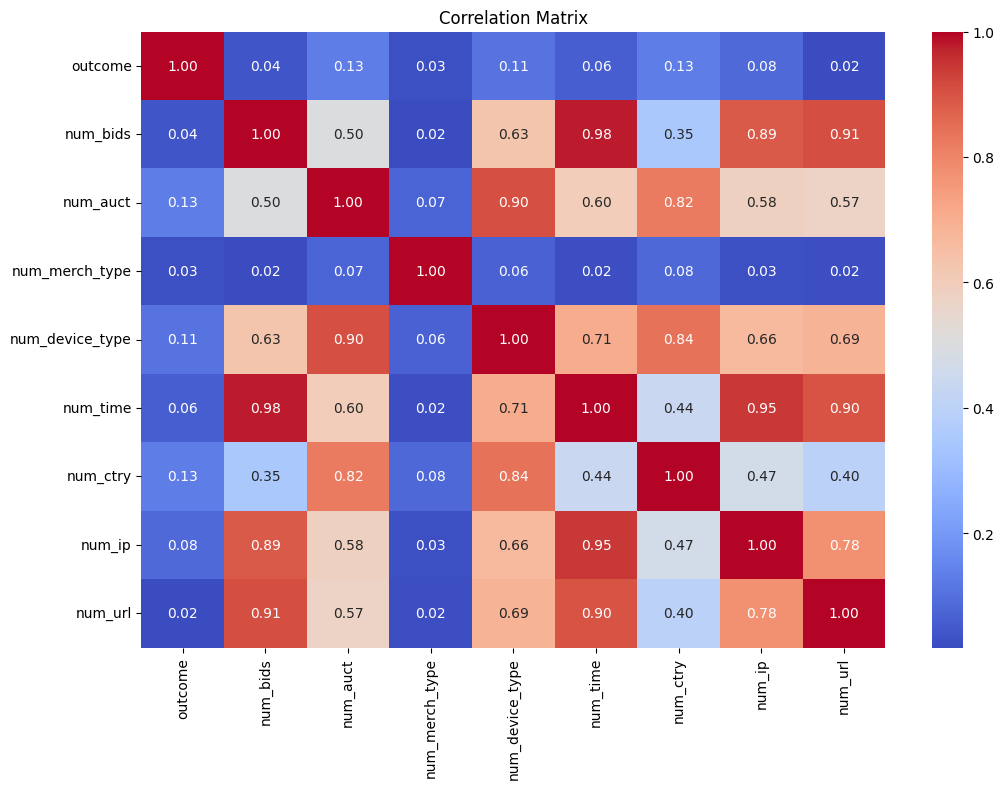

In [14]:
# correlations between all numeric features in the dataset
corr_matrix = train_set.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

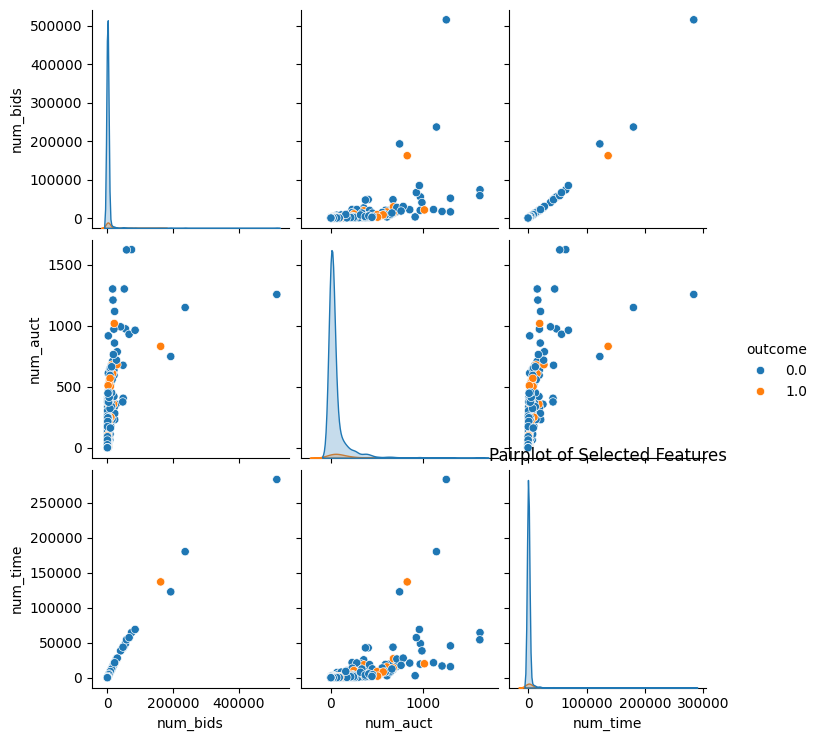

In [15]:
# relationships between number of bids, auctions, and time
sns.pairplot(train_set, vars=['num_bids', 'num_auct', 'num_time'], hue='outcome')
plt.title('Pairplot of Selected Features')
plt.show()

### Creating the Models

#### Random Forest Model

In [16]:
# drop bidder_id and outcome as they are unuseful for training the model
X_train = train_set.drop(columns=['bidder_id', 'outcome'])
y_train = train_set['outcome']

In [17]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [18]:
# print the class distribution
print("\nClass Distribution before SMOTE:")
print(pd.Series(y_train).value_counts())


Class Distribution before SMOTE:
0.0    1527
1.0      83
Name: outcome, dtype: int64


In [19]:
# handling class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [20]:
print("\nClass Distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Class Distribution after SMOTE:
0.0    1527
1.0    1527
Name: outcome, dtype: int64


In [21]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [22]:
# fit the model to the resampled data
rf_classifier.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [23]:
# create y_val prediction on X_val
y_val_pred = rf_classifier.predict(X_val)

In [24]:
# classification report
print("Classification Report:")
print(classification_report(y_val, y_val_pred))

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       383
         1.0       0.41      0.60      0.49        20

    accuracy                           0.94       403
   macro avg       0.70      0.78      0.73       403
weighted avg       0.95      0.94      0.94       403



In [25]:
# confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Confusion Matrix:
[[366  17]
 [  8  12]]


### Logistic Regression Model

In [26]:
# train the model
X_train_LR = X_train
X_train_LR = sm.add_constant(X_train_LR)
y_train_LR = y_train

In [27]:
# print the model summary
logreg01 = sm.Logit(y_train_LR, X_train_LR).fit()
logreg01.summary2()

Optimization terminated successfully.
         Current function value: 0.194180
         Iterations 11


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Method:           MLE       
Dependent Variable: outcome          Pseudo R-squared: 0.044     
Date:               2024-04-15 18:59 AIC:              643.2591  
No. Observations:   1610             BIC:              691.7150  
Df Model:           8                Log-Likelihood:   -312.63   
Df Residuals:       1601             LL-Null:          -326.93   
Converged:          1.0000           LLR p-value:      0.00037244
No. Iterations:     11.0000          Scale:            1.0000    
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const             -3.8449   1.2007 -3.2023 0.0014 -6.1981 -1.4917
num_bids          -0.0003   0.0005 -0.5708 0.5681 -0.0014  0.0007
num_auct           0.0028   0.0014  2.0335 0.0420  0.0001  0.0055
num_merch_type     0.6384   1.2021  0.5311 0.5953 -1.7176  2.9945
num_device_type   -0.0002   0.0018 -0.0944 0.9248 -0.0038  0.0034
num_time           0.0003   0.0006  0.4231 0.6722 -0.0009  0.0014
num_ctry           0.0057   0.0086  0.6644 0.5064 -0.0112  0.0227
num_ip             0.0001   0.0001  1.3594 0.1740 -0.0001  0.0004
num_url           -0.0001   0.0001 -1.2469 0.2124 -0.0004  0.0001
=================================================================

"""

In [28]:
# validate the model
X_validate_LR = X_val
X_validate_LR = sm.add_constant(X_validate_LR)
y_validate_LR = y_val

In [29]:
# summary of the model
logreg02 = sm.Logit(y_validate_LR, X_validate_LR).fit()
logreg02.summary2()

         Current function value: 0.182632
         Iterations: 35


C:\Users\tysir\miniconda3\envs\virtual4\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
=========================================================================
Model:                  Logit               Method:              MLE     
Dependent Variable:     outcome             Pseudo R-squared:    0.075   
Date:                   2024-04-15 18:59    AIC:                 165.2011
No. Observations:       403                 BIC:                 201.1915
Df Model:               8                   Log-Likelihood:      -73.601 
Df Residuals:           394                 LL-Null:             -79.559 
Converged:              0.0000              LLR p-value:         0.15491 
No. Iterations:         35.0000             Scale:               1.0000  
-------------------------------------------------------------------------
                 Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------
const           -23.0837 42021.8170 -0.0005 0.9996 -82384.3316 82338.1643
num_bids         -0.0010     0.0013 -0.8060 0.4202     -0.0036     0.0015
num_auct         -0.0043     0.0043 -1.0005 0.3171     -0.0126     0.0041
num_merch_type   19.9332 42021.8170  0.0005 0.9996 -82341.3147 82381.1812
num_device_type  -0.0038     0.0043 -0.9001 0.3681     -0.0122     0.0045
num_time          0.0013     0.0014  0.9413 0.3465     -0.0014     0.0040
num_ctry          0.0332     0.0229  1.4501 0.1470     -0.0117     0.0782
num_ip            0.0000     0.0004  0.0388 0.9691     -0.0008     0.0008
num_url          -0.0001     0.0002 -0.5390 0.5899     -0.0005     0.0003
=========================================================================

"""

In [30]:
#  predicting the values and creating a confusion matrix
pred = logreg01.predict(X_validate_LR)
predicted = (logreg01.predict(X_validate_LR) > 0.5).astype(int)
confusion_matrix(y_validate_LR, predicted)

array([[382,   1],
       [ 19,   1]], dtype=int64)

In [31]:
# True Positives, False Positives, False Negatives, and True Negatives
cm = confusion_matrix(y_validate_LR, predicted)
cm
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]
print('TN: ', TN,
'\nFP: ', FP,
'\nFN: ', FN,
'\nTP: ', TP)

TN:  382 
FP:  1 
FN:  19 
TP:  1


In [32]:
# print the accuracy, sensitivity, and precision of the model
accuracy_LR = (TP+TN)/(TP+TN+FP+FN)
sensitivity_LR = TP/(TP+FN)
precision_LR = TP/(TP+FP)

In [33]:
print('Logistic Regression Accuracy:',accuracy_LR,
      '\nLogistic Regression Precision:',precision_LR,
      '\nLogistic Regression sensitivity:',sensitivity_LR)

Logistic Regression Accuracy: 0.9503722084367245 
Logistic Regression Precision: 0.5 
Logistic Regression sensitivity: 0.05


#### Decision Tree Classifier 

In [34]:
dt_classifier = DecisionTreeClassifier(random_state=42)

In [35]:
# fit the model on the resampled training data
dt_classifier.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [36]:
# predict on the validation set
y_val_pred_dt = dt_classifier.predict(X_val)

In [37]:
# print the classification report
print("Decision Tree Classification Report:")
print(classification_report(y_val, y_val_pred_dt))

Decision Tree Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96       383
         1.0       0.32      0.55      0.41        20

    accuracy                           0.92       403
   macro avg       0.65      0.74      0.68       403
weighted avg       0.94      0.92      0.93       403



In [38]:
# print the confusion matrix
print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_dt))

Decision Tree Confusion Matrix:
[[360  23]
 [  9  11]]
